Follwing classes are there : 
 ['Alligator Cracks', 'Delamination', 'Longitudinal Cracks', 'Transverse Cracks']
Length of Train Data : 295
Length of Validation Data : 127


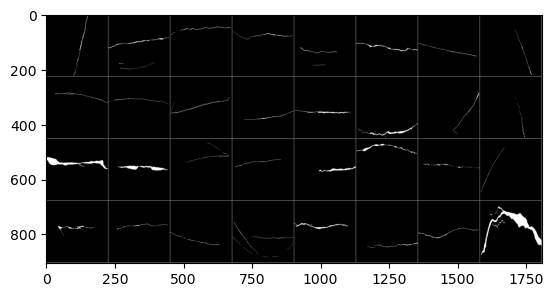

Longitudinal Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Longitudinal Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Delamination Longitudinal Cracks Longitudinal Cracks Delamination Delamination Transverse Cracks Transverse Cracks Delamination Transverse Cracks Transverse Cracks Longitudinal Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Delamination Transverse Cracks Transverse Cracks Delamination
[INFO] training the network...


  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1

<Figure size 640x480 with 0 Axes>

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

from random import *
from tqdm.notebook import tqdm, trange
from time import sleep
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from warnings import filterwarnings
filterwarnings('ignore')

  
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    plt.savefig('labels.JPG')
    
##  codes for data augmentation
train_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), ## tamim: image will move left and right
    transforms.RandomVerticalFlip(p=0.5), ## tamim: image will come to eye vertically
    transforms.RandomRotation(degrees=(.5, 5)), ## very small rotation of the cracks
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


test_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), ## tamim: image will move left and right
    transforms.RandomVerticalFlip(p=0.5), ## tamim: image will come to eye vertically
    transforms.RandomRotation(degrees=(.5, 5)), ## very small rotation of the cracks
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

##  codes for data augmentation
train_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), ## tamim: image will move left and right
    transforms.RandomVerticalFlip(p=0.5), ## tamim: image will come to eye vertically
    transforms.RandomRotation(degrees=(.5, 5)), ## very small rotation of the cracks
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


test_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), ## tamim: image will move left and right
    transforms.RandomVerticalFlip(p=0.5), ## tamim: image will come to eye vertically
    transforms.RandomRotation(degrees=(.5, 5)), ## very small rotation of the cracks
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

## Load data
from torchvision.datasets import ImageFolder

data = ImageFolder("D:\\SPRING 2023\\MS_Thesis\\MASTER'S THESIS\\Thesis results\\Data\\Data_Structure(Annotated)", transform=train_trans , )

test_folder= ImageFolder("D:\\SPRING 2023\\MS_Thesis\\MASTER'S THESIS\\DATA_iPhone_13_Pro_Max", transform=test_trans, )

batch_size = 32
num_classes = 4
learning_rate = 0.0001
num_epochs = 10

print("Follwing classes are there : \n",data.classes)

classes = ('Alligator Cracks', 'Delamination', 'Longitudinal Cracks', 'Transverse Cracks')

len(data)

##Splitting Data and Prepare Batches: 
## Source: https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48 
val_size = 127 ##  Tamim:30% data for validation ## 
train_size = len(data) - val_size 


train_loader,val_loader = random_split(data,[train_size,val_size]) ## To randomly split the images into training and testing, PyTorch provides random_split()
print(f"Length of Train Data : {len(train_loader)}")                   ## changed the folder names
print(f"Length of Validation Data : {len(val_loader)}")

# Splitting train and validation data on batches

train_loader = torch.utils.data.DataLoader(train_loader, shuffle=True, batch_size=batch_size) ## defined train data & val data
val_loader = torch.utils.data.DataLoader(val_loader, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_folder, shuffle=False, batch_size=batch_size)


# visualize images of a single batch

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## define model

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

    
## Change the class 4 from 1

class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=4, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out
    
#https://amaarora.github.io/2020/09/13/unet.html
#https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201

model = UNet()

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(train_loader):
		# send the input to the device
		#(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = criterion(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()